# Differences between the wettest and driest ensemble members around NYC

## Setup

In [25]:
# Import statements

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from xskillscore import resample_iterations_idx

from xbootstrap import block_bootstrap
from dask.diagnostics import ProgressBar

In [2]:
# Create function to open_mfdataset and add time dimension

def load_data(init : str, keyword : str) -> xr.Dataset:
    
    # Note that this function depends on a consistent file structure so if you
    # change that, you'll need to change this function.
    # First, determine starting date
    start_date = "2021-09-02" if init in ["00Z","01Z"] else "2021-09-01"
    new_dates = xr.date_range(
        start=start_date+" "+init[:-1]+":00:00",
        end="2021-09-02 "+str((int(init[:-1])+6)%24).zfill(2)+":00:00",
        freq="5min",
        use_cftime=True
    )

    # read in data
    data = xr.open_mfdataset(
        "/mnt/drive2/wof-runs/post-processed/"+init+"/wofs_"+keyword.upper()+"*.nc",
        concat_dim="time",combine="nested"
    )
    data["time"] = new_dates
    return(data)

In [8]:
def time_mean(da:xr.DataArray,start:str,end:str) -> xr.DataArray:
    return(da.sel(time=slice(start,end)).mean(dim="time"))

def fix_ne(da:xr.DataArray) -> xr.DataArray:
    da["ne"] = range(5)
    return(da)

In [3]:
# Read in 20-23Z simulations with our load_data function to fix the calendar

ens = [load_data(i,"ens") for i in ["20Z","21Z","22Z","23Z"]]
ens = [e.assign_coords(lat=e.lat,lon=e.lon,ne=e.ne) for e in ens]

svr = [load_data(i,"svr") for i in ["20Z","21Z","22Z","23Z"]]
svr = [s.assign_coords(lat=s.lat,lon=s.lon,ne=s.ne) for s in svr]

env = [load_data(i,"env") for i in ["20Z","21Z","22Z","23Z"]]
env = [e.assign_coords(lat=e.lat,lon=e.lon,ne=e.ne) for e in env]

## Create ensembles

In [4]:
# Set desired latitude and longitude
nyc_lat,nyc_lon = 40.7826,-73.9656

# Isolate xlat and xlon for ease of use
lat = ens[0].xlat.isel(time=0)
lon = ens[0].xlon.isel(time=0)

# Calculate the Euclidean distance between lat and lon values and the desired point
distance = np.sqrt((lat-nyc_lat)**2 + (lon-nyc_lon)**2)

# Find where the distance is minimized
nyc_inds = distance.argmin(dim=["NY","NX"])
NY_ind, NX_ind = int(nyc_inds["NY"]),int(nyc_inds["NX"])

In [5]:
# We are going to sort by the area averaged precip
rain_1to2Z = [e.rain.sel(time=slice("2021-09-02 01:05:00",
                                   "2021-09-02 02:05:00")).sum(dim="time") for e in ens]

# Calculate the area average hourly precip for a box around Central Park
aoi_48km = [r.isel(
    lat=slice(NY_ind-8,NY_ind+8),
    lon=slice(NX_ind-8,NX_ind+8)
) for r in rain_1to2Z]
avg_48km = [a.mean(dim=["lat","lon"]) for a in aoi_48km]

In [6]:
# Get the indices of the wettest and driest ensemble members
ne_wet = [a.ne.where(
    a > a.quantile(0.75,dim="ne")).dropna(dim="ne") for a in avg_48km]
ne_dry = [a.ne.where(
    a < a.quantile(0.25,dim="ne")).dropna(dim="ne") for a in avg_48km]

In [7]:
# Select the wettest and driest members

ens_wet = [ens[i].sel(ne=ne_wet[i]).drop_vars("quantile") for i in range(len(ens))]
ens_dry = [ens[i].sel(ne=ne_dry[i]).drop_vars("quantile") for i in range(len(ens))]

svr_wet = [svr[i].sel(ne=ne_wet[i]).drop_vars("quantile") for i in range(len(svr))]
svr_dry = [svr[i].sel(ne=ne_dry[i]).drop_vars("quantile") for i in range(len(svr))]

env_wet = [env[i].sel(ne=ne_wet[i]).drop_vars("quantile") for i in range(len(env))]
env_dry = [env[i].sel(ne=ne_dry[i]).drop_vars("quantile") for i in range(len(env))]

## CAPE

In [43]:
# Make a new init dimension to concatenate the DataArrays
init = xr.DataArray(data=["20Z","21Z","22Z","23Z"],dims="init")
init = init.assign_coords({"init":init})

# Take the time mean of the precipitable water

cape_23to00_all = xr.concat([time_mean(s.cape_ml,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00") for s in svr],dim=init).stack(
                            run=("ne","init")).chunk({"run":-1})
cape_00to01_all = xr.concat([time_mean(s.cape_ml,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00") for s in svr],dim=init).stack(
                            run=("ne","init")).chunk({"run":-1})
cape_23to00_wet = xr.concat([fix_ne(time_mean(s.cape_ml,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00")) for s in svr_wet],dim=init).stack(
                            run=("ne","init"))
cape_00to01_wet = xr.concat([fix_ne(time_mean(s.cape_ml,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00")) for s in svr_wet],dim=init).stack(
                            run=("ne","init"))
cape_23to00_dry = xr.concat([fix_ne(time_mean(s.cape_ml,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00")) for s in svr_dry],dim=init).stack(
                            run=("ne","init"))
cape_00to01_dry = xr.concat([fix_ne(time_mean(s.cape_ml,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00")) for s in svr_dry],dim=init).stack(
                            run=("ne","init"))
    
# Bootstrap!

with ProgressBar():
    set1_23to00 = resample_iterations_idx(
        cape_23to00_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set2_23to00 = resample_iterations_idx(
        cape_23to00_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set1_00to01 = resample_iterations_idx(
        cape_00to01_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set2_00to01 = resample_iterations_idx(
        cape_00to01_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    

[########################################] | 100% Completed | 56.96 s
[########################################] | 100% Completed | 55.59 ss
[####################################### ] | 99% Completed | 40.43 sms

In [ ]:
# Calculate the mean difference and create bootstrap sample for comparison
cape_diff_23to00 = (cape_23to00_wet - cape_23to00_dry).mean(dim="run")
cape_diff_00to01 = (cape_00to01_wet - cape_00to01_dry).mean(dim="run")
cape_boot_23to00 = set1_23to00 - set2_23to00
cape_boot_00to01 = set1_00to01 - set2_00to01

# # Create mask for hatching on plot
cape_mask_23to00 = (((cape_diff_23to00 > cape_boot_23to00.quantile(0.95,dim="iteration"))|
                   (cape_diff_23to00 < cape_boot_23to00.quantile(0.05,dim="iteration")))&
                   (np.fabs(cape_diff_23to00) > 0.03))
cape_mask_00to01 = (((cape_diff_00to01 > cape_boot_00to01.quantile(0.95,dim="iteration"))|
                   (cape_diff_00to01 < cape_boot_00to01.quantile(0.05,dim="iteration")))&
                   (np.fabs(cape_diff_00to01) > 0.03))

In [58]:
# Grab the 23-00Z CAPE
cape_23to00_all = [s.cape_ml.sel(time=slice("2021-09-01 23:00:00",
                                        "2021-09-02 00:00:00")).mean(dim="time")
                                        for s in svr]
cape_23to00_wet = [s.cape_ml.sel(time=slice("2021-09-01 23:00:00",
                                    "2021-09-02 00:00:00")).mean(dim="time") 
                                    for s in svr_wet]
# Overwrite the ensemble number dimension for compatibility
for c in cape_23to00_wet:
    c["ne"] = range(5)
cape_23to00_dry = [s.cape_ml.sel(time=slice("2021-09-01 23:00:00",
                                    "2021-09-02 00:00:00")).mean(dim="time")
                                      for s in svr_dry]
for c in cape_23to00_dry:
    c["ne"] = range(5)

# Make a new init dimension to concatenate the DataArrays
init = xr.DataArray(data=["20Z","21Z","22Z","23Z"],dims="init")
init = init.assign_coords({"init":init})

# Concatenate
cape_23to00_all = xr.concat(cape_23to00_all,dim=init).stack(run=("ne","init")
                                                            ).chunk({"run":-1})
cape_23to00_dry = xr.concat(cape_23to00_dry,dim=init).stack(run=("ne","init"))
cape_23to00_wet = xr.concat(cape_23to00_wet,dim=init).stack(run=("ne","init"))

# Create n=1000 bootstrap
with ProgressBar():
    set1 = block_bootstrap(
        cape_23to00_all,blocks={"run":20},n_iteration=10000
                          ).mean(dim="run").compute()
    set2 = block_bootstrap(
        cape_23to00_all,blocks={"run":20},n_iteration=10000
                          ).mean(dim="run").compute()

[########################################] | 100% Completed | 156.81 s
[########################################] | 100% Completed | 147.47 s


In [86]:
# Calculate the mean difference and create bootstrap sample for comparison
cape_wet_minus_dry = (cape_23to00_wet - cape_23to00_dry).mean(dim="run")
cape_bootstrap = set1 - set2

# Create mask for hatching on plot
mask = (((cape_wet_minus_dry>cape_bootstrap.quantile(0.95,dim="iteration"))|
        (cape_wet_minus_dry<cape_bootstrap.quantile(0.05,dim="iteration")))&
        ((cape_wet_minus_dry>150)|(cape_wet_minus_dry<-150)))

Text(0.5, 0.98, '23Z-00Z ML-CAPE')

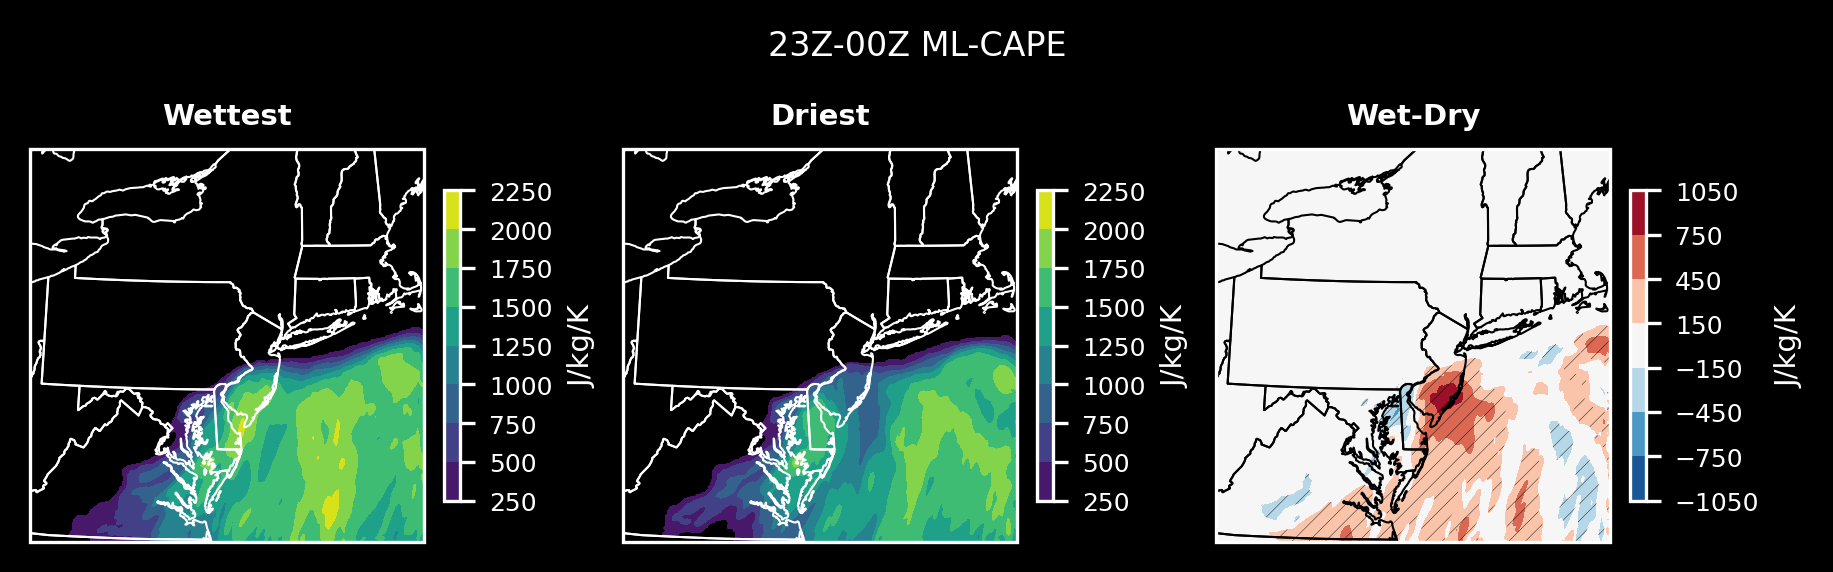

In [85]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth

plt.style.use("dark_background")

linewidth=0.5
titles = ["Wettest","Driest","Wet-Dry"]
z = [cape_23to00_wet,cape_23to00_dry,cape_wet_minus_dry]
lat=ens[0].xlat.isel(time=0).squeeze()
lon=ens[0].xlon.isel(time=0).squeeze()

proj = ccrs.LambertConformal(central_longitude=ens[0].attrs['CEN_LON'],
                             central_latitude=ens[0].attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,2))

for i,ax in enumerate(axes.flatten()):
    if(i!=2):
        p = ax.contourf(lon,lat,z[i].mean(dim="run").where(
            z[i].mean(dim="run") > 250),
                        transform=ccrs.PlateCarree(),levels=range(250,2251,250))
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="white")
    else:
        p = ax.contourf(lon,lat,z[i],
                        transform=ccrs.PlateCarree(),levels=range(-1050,1051,300),
                        cmap="RdBu_r")
        m = ax.contourf(lon,lat,mask,colors="none",levels=[0.5,1.5],hatches=["//////",""],
                        transform=ccrs.PlateCarree())
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="black")
    PCM = ax.get_children()[2]

    cbar = plt.colorbar(p,ax=ax,shrink=0.6)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label("J/kg/K",fontsize=7)

    ax.set_title(titles[i],fontsize=7, fontweight="bold")
plt.suptitle("23Z-00Z ML-CAPE",fontsize=8)

plt.show()

In [88]:
# Repeat for 00-01Z
cape_00to01_all = [s.cape_ml.sel(time=slice("2021-09-01 00:00:00",
                                        "2021-09-02 01:00:00")).mean(dim="time")
                                        for s in svr]
cape_00to01_wet = [s.cape_ml.sel(time=slice("2021-09-01 00:00:00",
                                    "2021-09-02 01:00:00")).mean(dim="time") 
                                    for s in svr_wet]
# Overwrite the ensemble number dimension for compatibility
for c in cape_00to01_wet:
    c["ne"] = range(5)
cape_00to01_dry = [s.cape_ml.sel(time=slice("2021-09-01 00:00:00",
                                    "2021-09-02 01:00:00")).mean(dim="time")
                                      for s in svr_dry]
for c in cape_00to01_dry:
    c["ne"] = range(5)

# Concatenate
cape_00to01_all = xr.concat(cape_00to01_all,dim=init).stack(run=("ne","init")
                                                            ).chunk({"run":-1})
cape_00to01_dry = xr.concat(cape_00to01_dry,dim=init).stack(run=("ne","init"))
cape_00to01_wet = xr.concat(cape_00to01_wet,dim=init).stack(run=("ne","init"))

# Create n=1000 bootstrap
with ProgressBar():
    set1 = block_bootstrap(
        cape_00to01_all,blocks={"run":20},n_iteration=10000
                          ).mean(dim="run").compute()
    set2 = block_bootstrap(
        cape_00to01_all,blocks={"run":20},n_iteration=10000
                          ).mean(dim="run").compute()

[########################################] | 100% Completed | 148.58 s
[########################################] | 100% Completed | 133.71 s


In [ ]:
# Calculate the mean difference and create bootstrap sample for comparison
cape_diff_23to00 = (cape_23to00_wet - cape_23to00_dry).mean(dim="run")
cape_diff_00to01 = (cape_00to01_wet - cape_00to01_dry).mean(dim="run")
cape_boot_23to00 = set1_23to00 - set2_23to00
cape_boot_00to01 = set1_00to01 - set2_00to01

# # Create mask for hatching on plot
cape_mask_23to00 = (((pw_diff_23to00 > pw_boot_23to00.quantile(0.95,dim="iteration"))|
                   (pw_diff_23to00 < pw_boot_23to00.quantile(0.05,dim="iteration")))&
                   (np.fabs(pw_diff_23to00) > 0.03))
cape_mask_00to01 = (((pw_diff_00to01 > pw_boot_00to01.quantile(0.95,dim="iteration"))|
                   (pw_diff_00to01 < pw_boot_00to01.quantile(0.05,dim="iteration")))&
                   (np.fabs(pw_diff_00to01) > 0.03))

In [89]:
# Calculate the mean difference and create bootstrap sample for comparison
cape_diff_00to01 = (cape_00to01_wet - cape_00to01_dry).mean(dim="run")
cape_bootstrap = set1 - set2

# Create mask for hatching on plot
mask = (((cape_diff_00to01>cape_bootstrap.quantile(0.95,dim="iteration"))|
        (cape_diff_00to01<cape_bootstrap.quantile(0.05,dim="iteration")))&
        ((cape_diff_00to01>150)|(cape_diff_00to01<-150)))

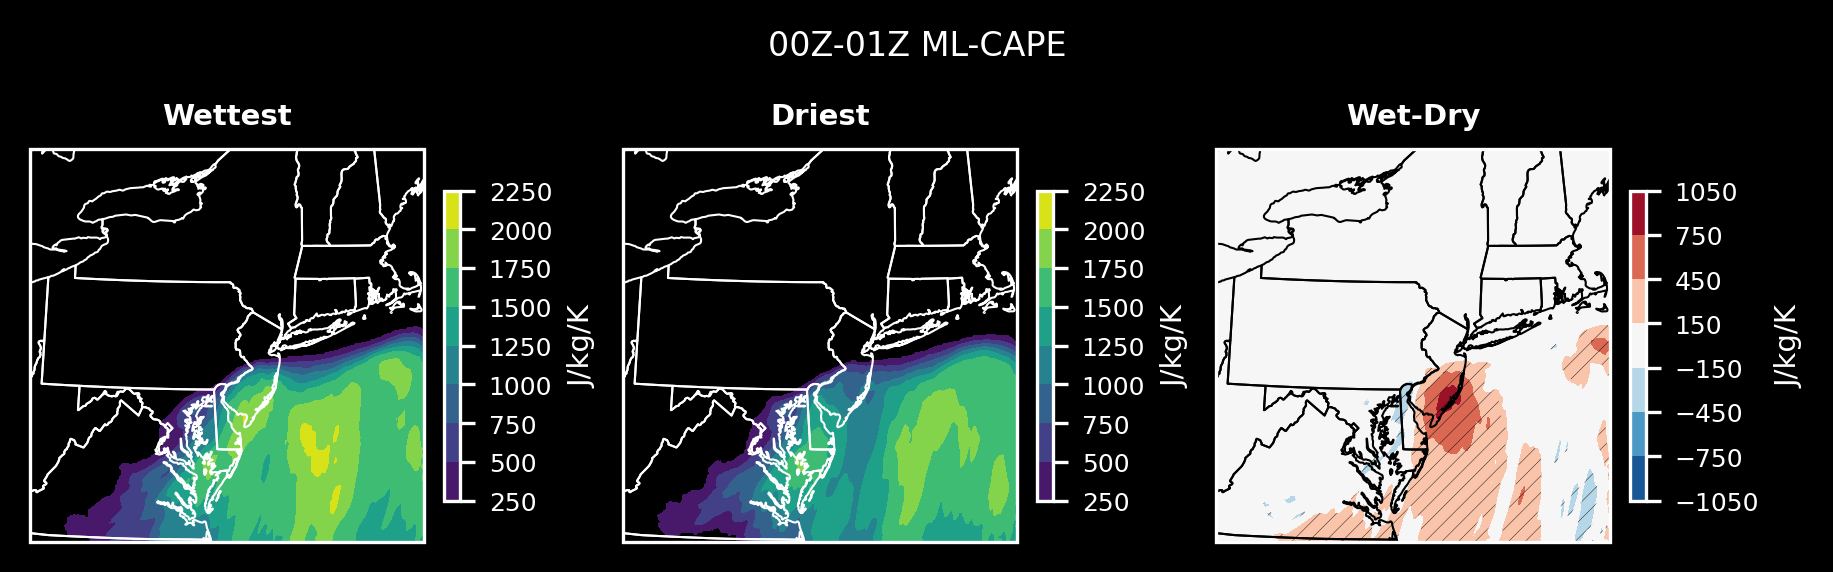

In [91]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth

plt.style.use("dark_background")

linewidth=0.5
titles = ["Wettest","Driest","Wet-Dry"]
z = [cape_00to01_wet,cape_00to01_dry,cape_diff_00to01]
lat=ens[0].xlat.isel(time=0).squeeze()
lon=ens[0].xlon.isel(time=0).squeeze()

proj = ccrs.LambertConformal(central_longitude=ens[0].attrs['CEN_LON'],
                             central_latitude=ens[0].attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,2))

for i,ax in enumerate(axes.flatten()):
    if(i!=2):
        p = ax.contourf(lon,lat,z[i].mean(dim="run").where(
            z[i].mean(dim="run") > 250),
                        transform=ccrs.PlateCarree(),levels=range(250,2251,250))
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="white")
    else:
        p = ax.contourf(lon,lat,z[i],
                        transform=ccrs.PlateCarree(),levels=range(-1050,1051,300),
                        cmap="RdBu_r")
        m = ax.contourf(lon,lat,mask,colors="none",levels=[0.5,1.5],hatches=["//////",""],
                        transform=ccrs.PlateCarree())
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="black")
    PCM = ax.get_children()[2]

    cbar = plt.colorbar(p,ax=ax,shrink=0.6)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label("J/kg/K",fontsize=7)

    ax.set_title(titles[i],fontsize=7, fontweight="bold")
plt.suptitle("00Z-01Z ML-CAPE",fontsize=8)

plt.show()

## PW

In [36]:
# Make a new init dimension to concatenate the DataArrays
init = xr.DataArray(data=["20Z","21Z","22Z","23Z"],dims="init")
init = init.assign_coords({"init":init})

# Take the time mean of the precipitable water

pw_23to00_all = xr.concat([time_mean(e.pw,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00") for e in env],dim=init).stack(
                            run=("ne","init")).chunk({"run":-1})
pw_00to01_all = xr.concat([time_mean(e.pw,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00") for e in env],dim=init).stack(
                            run=("ne","init")).chunk({"run":-1})
pw_23to00_wet = xr.concat([fix_ne(time_mean(e.pw,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00")) for e in env_wet],dim=init).stack(
                            run=("ne","init"))
pw_00to01_wet = xr.concat([fix_ne(time_mean(e.pw,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00")) for e in env_wet],dim=init).stack(
                            run=("ne","init"))
pw_23to00_dry = xr.concat([fix_ne(time_mean(e.pw,"2021-09-01 23:00:00",
                           "2021-09-02 00:00:00")) for e in env_dry],dim=init).stack(
                            run=("ne","init"))
pw_00to01_dry = xr.concat([fix_ne(time_mean(e.pw,"2021-09-02 00:00:00",
                           "2021-09-02 01:00:00")) for e in env_dry],dim=init).stack(
                            run=("ne","init"))
    
# Bootstrap!

with ProgressBar():
    set1_23to00 = resample_iterations_idx(
        pw_23to00_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set2_23to00 = resample_iterations_idx(
        pw_23to00_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set1_00to01 = resample_iterations_idx(
        pw_00to01_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    set2_00to01 = resample_iterations_idx(
        pw_00to01_all,1000,dim="run",replace=False,dim_max=20
        ).mean(dim="run").compute()
    

[########################################] | 100% Completed | 56.39 ss
[########################################] | 100% Completed | 60.14 ss
[########################################] | 100% Completed | 49.65 ss
[########################################] | 100% Completed | 51.40 ss


In [40]:
# Calculate the mean difference and create bootstrap sample for comparison
pw_diff_23to00 = (pw_23to00_wet - pw_23to00_dry).mean(dim="run")
pw_diff_00to01 = (pw_00to01_wet - pw_00to01_dry).mean(dim="run")
pw_boot_23to00 = set1_23to00 - set2_23to00
pw_boot_00to01 = set1_00to01 - set2_00to01

# # Create mask for hatching on plot
pw_mask_23to00 = (((pw_diff_23to00 > pw_boot_23to00.quantile(0.95,dim="iteration"))|
                   (pw_diff_23to00 < pw_boot_23to00.quantile(0.05,dim="iteration")))&
                   (np.fabs(pw_diff_23to00) > 0.03))
pw_mask_00to01 = (((pw_diff_00to01 > pw_boot_00to01.quantile(0.95,dim="iteration"))|
                   (pw_diff_00to01 < pw_boot_00to01.quantile(0.05,dim="iteration")))&
                   (np.fabs(pw_diff_00to01) > 0.03))

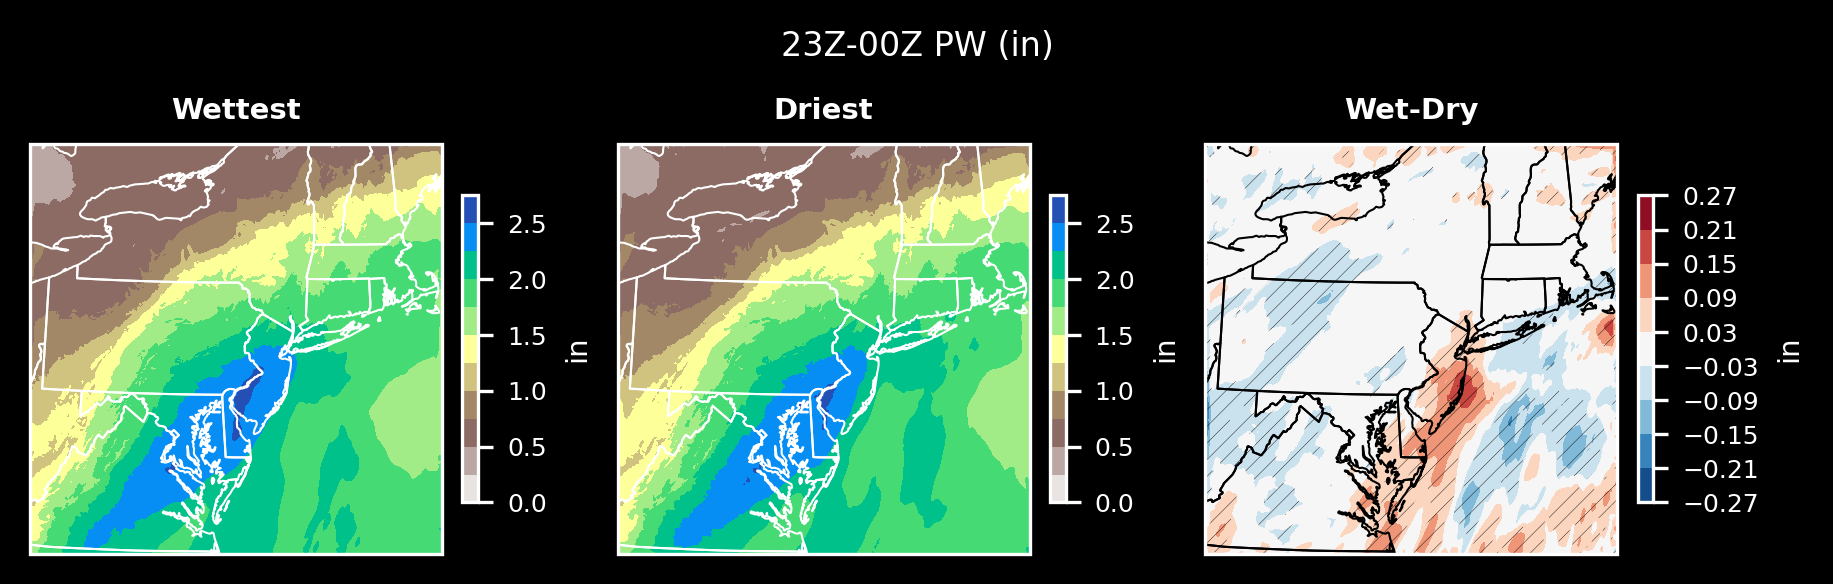

In [41]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth

plt.style.use("dark_background")

linewidth=0.5
titles = ["Wettest","Driest","Wet-Dry"]
z = [pw_23to00_wet,pw_23to00_dry,pw_diff_23to00]
lat=ens[0].xlat.isel(time=0).squeeze()
lon=ens[0].xlon.isel(time=0).squeeze()

proj = ccrs.LambertConformal(central_longitude=ens[0].attrs['CEN_LON'],
                             central_latitude=ens[0].attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,2))

for i,ax in enumerate(axes.flatten()):
    if(i!=2):
        p = ax.contourf(lon,lat,z[i].mean(dim="run"),cmap="terrain_r",
                        transform=ccrs.PlateCarree(),levels=np.arange(0,2.76,0.25))
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="white")
    else:
        p = ax.contourf(lon,lat,z[i],
                        transform=ccrs.PlateCarree(),
                        cmap="RdBu_r",levels=np.arange(-0.27,0.28,0.06))
        m = ax.contourf(lon,lat,pw_mask_23to00,colors="none",levels=[0.5,1.5],hatches=["//////",""],
                        transform=ccrs.PlateCarree())
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="black")

    cbar = plt.colorbar(p,ax=ax,shrink=0.6)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label("in",fontsize=7)

    ax.set_title(titles[i],fontsize=7, fontweight="bold")
plt.suptitle("23Z-00Z PW (in)",fontsize=8)

plt.show()

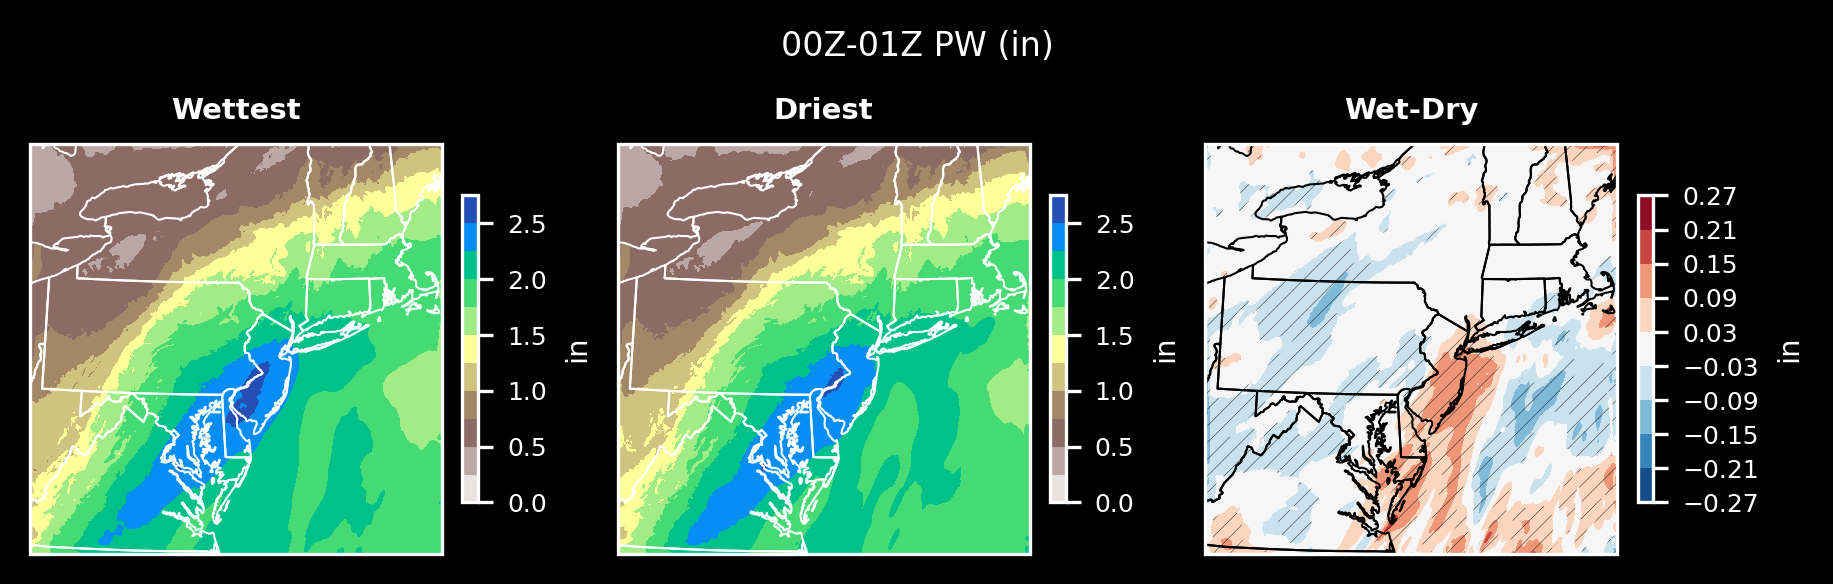

In [42]:
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.1  # previous pdf hatch linewidth

plt.style.use("dark_background")

linewidth=0.5
titles = ["Wettest","Driest","Wet-Dry"]
z = [pw_00to01_wet,pw_00to01_dry,pw_diff_00to01]
lat=ens[0].xlat.isel(time=0).squeeze()
lon=ens[0].xlon.isel(time=0).squeeze()

proj = ccrs.LambertConformal(central_longitude=ens[0].attrs['CEN_LON'],
                             central_latitude=ens[0].attrs['CEN_LAT'],
                             standard_parallels=(30,60))

fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),
                         dpi=300,layout="constrained",figsize=(6,2))

for i,ax in enumerate(axes.flatten()):
    if(i!=2):
        p = ax.contourf(lon,lat,z[i].mean(dim="run"),cmap="terrain_r",
                        transform=ccrs.PlateCarree(),levels=np.arange(0,2.76,0.25))
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="white")
    else:
        p = ax.contourf(lon,lat,z[i],
                        transform=ccrs.PlateCarree(),
                        cmap="RdBu_r",levels=np.arange(-0.27,0.28,0.06))
        m = ax.contourf(lon,lat,pw_mask_00to01,colors="none",levels=[0.5,1.5],hatches=["//////",""],
                        transform=ccrs.PlateCarree())
        p.axes.add_feature(cfeature.STATES,linewidth=linewidth,edgecolor="black")

    cbar = plt.colorbar(p,ax=ax,shrink=0.6)
    cbar.ax.tick_params(labelsize=6)
    cbar.set_label("in",fontsize=7)

    ax.set_title(titles[i],fontsize=7, fontweight="bold")
plt.suptitle("00Z-01Z PW (in)",fontsize=8)

plt.show()